# Small World Graphs

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 3

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [3]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [4]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [5]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [6]:
lattice = make_ring_lattice(10, 4)

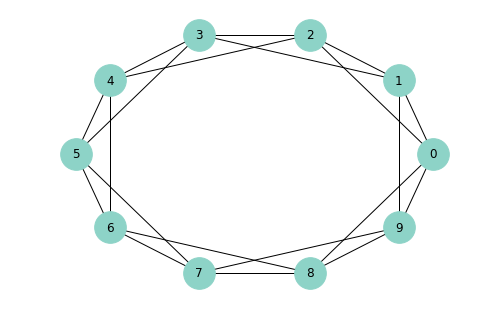

In [7]:
nx.draw_circular(lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)
plt.savefig('chap03-1.pdf')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=2` or `k=5`.

## WS graph

To make a WS, you start with a ring lattice and then rewire.

In [8]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [9]:
from numpy.random import choice

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G.nodes())
    for edge in G.edges():
        if flip(p):
            u, v = edge
            choices = nodes - {u} - set(G[u])
            new_v = choice(tuple(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

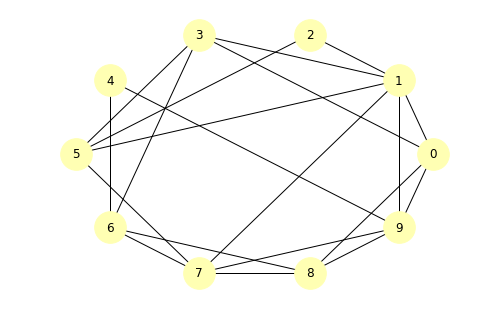

In [10]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color=COLORS[1], 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [11]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

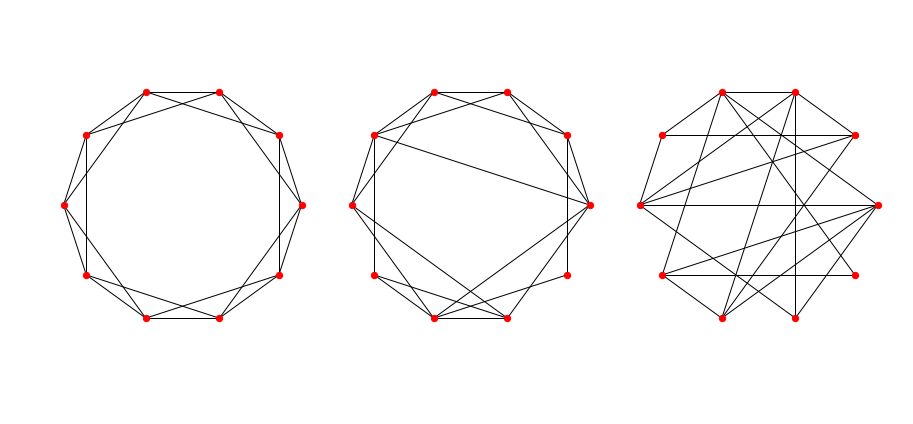

In [12]:
n = 10
k = 4
ns = 40

thinkplot.preplot(cols=3)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1)
plt.savefig('chap03-2.pdf')

**Exercise:** What is the order of growth of `rewire`?

# Solution goes here
First, rewire iterates through every $m$ edges. Within each loop, we do a set subtraction, which is in $O(n)$, where n is the length of the set, the number of nodes. None of the other statements within the loop are consequential, so the total order of growth is in $O(m*n)$

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [13]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / total

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [14]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cc = np.mean([node_clustering(G, node) for node in G])
    return cc

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [15]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [16]:
clustering_coefficient(lattice)

0.5

Correct.

**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.

In [17]:
# Solution goes here
def node_clustering_list_comp(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = [1 for v,w in all_pairs(neighbors) if G.has_edge(v,w)]
    exist = sum(exist)
    return exist / total

**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

# Solution goes here
For a graph with $n$ nodes and $m$ edges, and a node with $k$ neighbors, we get the length of $k$ which is in $O(k)$. We iterate through `all_pairs(k)`, which is in $O(k^2)$. The `has_edge` is done in constant time, so the overall order of growth is in $O(k^2)$.

## Path length

The following function computes path lengths between all pairs of nodes

In [18]:
def path_lengths(G):
    length_map = nx.shortest_path_length(G)
    lengths = [length_map[u][v] for u, v in all_pairs(G)]
    return lengths

The characteristic path length is the mean path length for all pairs.

In [19]:
def characteristic_path_length(G):
    return np.mean(path_lengths(G))

On a complete graph, the average path length should be 1

In [20]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)

1.0

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [21]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.450450450450454

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [22]:
# Solution goes here
new_lattice = make_ring_lattice(10, 4)
characteristic_path_length(new_lattice)

1.6666666666666667

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [23]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes about a second on my computer:

In [24]:
%time run_one_graph(1000, 10, 0.01)

8.28667867868 0.644182539683
CPU times: user 9 s, sys: 124 ms, total: 9.12 s
Wall time: 9.17 s


(8.2866786786786779, 0.6441825396825398)

Now we'll run it with a range of values for `p`.

In [25]:
ps = np.logspace(-4, 0, 9)
print(ps)

[  1.00000000e-04   3.16227766e-04   1.00000000e-03   3.16227766e-03
   1.00000000e-02   3.16227766e-02   1.00000000e-01   3.16227766e-01
   1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [26]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns: sequence of (mpl, cc) pairs
    """
    res = {}
    for p in ps:
        print(p)
        res[p] = []
        for _ in range(iters):
            res[p].append(run_one_graph(n, k, p))
    return res

Here are the raw results

In [27]:
res = run_experiment(ps, n=50)

0.0001
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.7493877551 0.660353535354
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
0.000316227766017
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666666666667
2.95918367347 0.666

Now we have to extract them in a form we can plot

In [28]:
L = []
C = []
for p, t in sorted(res.items()):
    mpls, ccs = zip(*t)
    mpl = np.mean(mpls)
    cc = np.mean(ccs)
    L.append(mpl)
    C.append(cc)
    
print(L)
print(C)

[2.9486938775510212, 2.9591836734693882, 2.9435918367346945, 2.8464897959183677, 2.7190204081632654, 2.4504489795918367, 2.1814693877551017, 1.9593877551020404, 1.8954693877551019]
[0.66635101010100983, 0.66666666666666641, 0.66603535353535326, 0.66061565656565635, 0.65102424242424228, 0.61587215007215013, 0.51811123876123877, 0.30718910256410253, 0.20019850070809825]


And normalize them so they both start at 1.0

In [29]:
L = np.array(L) / L[0]
C = np.array(C) / C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

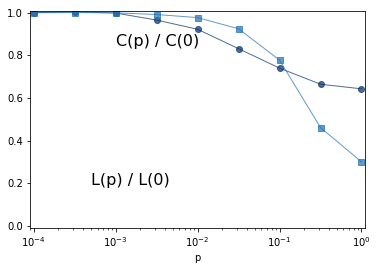

In [30]:
thinkplot.plot(ps, L, style='o-', linewidth=1)
thinkplot.plot(ps, C, style='s-', linewidth=1)
thinkplot.text(0.001, 0.9, 'C(p) / C(0)')
thinkplot.text(0.0005, 0.25, 'L(p) / L(0)')
thinkplot.config(xlabel='p', xscale='log',
                 xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])
plt.savefig('chap03-3.pdf')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [31]:
lattice = make_ring_lattice(10, 4)

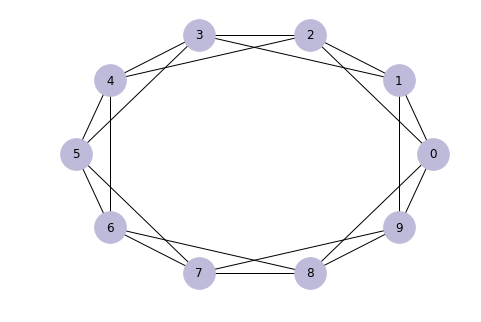

In [32]:
nx.draw_circular(lattice, 
                 node_color=COLORS[2], 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [33]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [34]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [35]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) 
            neighbors -= seen
            queue.extend(neighbors)
    return seen

It works, too.

In [36]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [37]:
def shortest_path_dijkstra(G, start):
    """Finds shortest paths from `start` to all other nodes.
    
    G: graph
    start: node to start at
    
    returns: make from node to path length
    """
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]) - set(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [38]:
lattice = make_ring_lattice(10, 4)

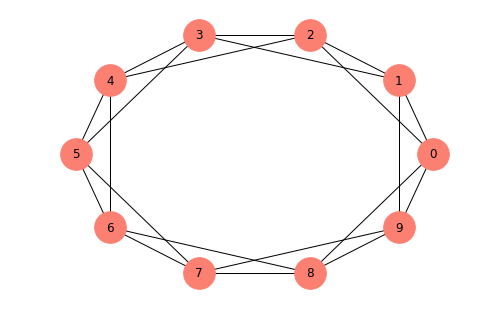

In [39]:
nx.draw_circular(lattice, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [40]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

And here's the result from NetworkX:

In [41]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

They are the same:

In [42]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [43]:
# Solution goes here
lattice = make_ring_lattice(1000, 10)
distances = shortest_path_dijkstra(lattice,0)
highest = max(distances, key=distances.get)
highest

496

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

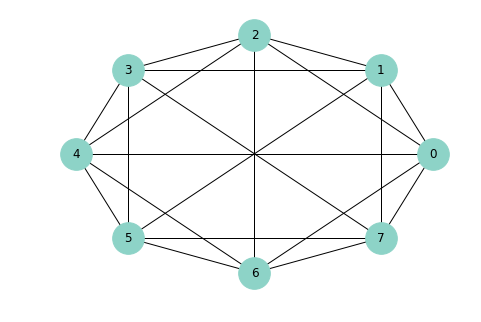

In [44]:
# Solution goes here
def opposite_edge(nodes):
    n = len(nodes)
    for i, u in enumerate(nodes):
        yield (u, nodes[(i+n//2)%n])

def make_regular_graph(n, k):
    # It seems that if we have an odd k, we must have an even n. Or else we should raise a value error.
    # https://en.wikipedia.org/wiki/Handshaking_lemma
    if not n > k:
        raise ValueError("n must be greater than k")
    if k%2 == 0:
        return make_ring_lattice(n, k)
    else:
        if n%2 != 0:
            raise ValueError("Must have even n for odd k")
        else:
            G = nx.Graph()
            nodes = range(n)
            G.add_nodes_from(nodes)
            G.add_edges_from(adjacent_edges(nodes, k//2))
            G.add_edges_from(opposite_edge(nodes))
            return G
    
    
nx.draw_circular(make_regular_graph(8,5), 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [45]:
def plain_bfs(G, source):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {source}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

# Solution goes here
This new `plain_bfs` first initializes a set and then another, both $O(1)$. It enters a while loop where it assigns `thislevel` and re-initializes `nextlevel`, also both $O(1)$. It then enters a while loop where it checks for membership in `seen` ($O(1)$), adds the element `v` to seen ($O(1)$), and updates `nextlevel` with the neighbors of `v` (average $O(k)$). `nextlevel` will be exhausted once we've visited every node, so the while loop iterates $O(n)$. The for loop operates $O(k)$. Overall, we have $O(n*k*k) = O(nk^2)$, which seems to be a longer implementation than $O(n+m)$.

In [46]:
# Solution goes here
lattice = make_ring_lattice(500, 10)

%timeit len(reachable_nodes_bfs(lattice, 0))

%timeit len(plain_bfs(lattice, 0))

100 loops, best of 3: 14.8 ms per loop
100 loops, best of 3: 2.64 ms per loop


# Solution goes here
Upon timing, we see that plain_bfs is quite a bit faster. I guess the difference between the order of growth is more than made up by the use of sets as opposed to deques.

In [47]:
# Solution goes here
def dijkstra_plain_bfs(G, start):
    dist = {start: 0}
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for node in thislevel:
            next_dist = dist[node] + 1
            for next_node in G[node]:
                if next_node not in dist or dist[next_node] > next_dist:
                    dist[next_node] = next_dist
                    nextlevel.add(next_node)
    return dist

ws = make_ws_graph(50, 6, 0.5)
test = shortest_path_dijkstra(ws, 0)
test1 = dijkstra_plain_bfs(ws, 0)
test == test1

True

**Exercise 3.5**: Experiment with a different variation of making small world graphs. Check out clustering (high?), path length (low?), degree (?)

In [48]:
# Solution goes here
# I'm trying the Newman-Watts-Strogatz model, which is similar to the WS but it doesn't replace edges, only adds
# https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.random_graphs.newman_watts_strogatz_graph.html

def make_nws_graph(n, k, p):
    """Makes a Newman-Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    nws = make_ring_lattice(n, k)
    addwire(nws, p)
    return nws

from numpy.random import choice

def addwire(G, p):
    nodes = set(G.nodes())
    for node in G.nodes():
        if flip(p):
            choices = nodes - {node} - set(G[node])
            new_v = choice(tuple(choices))
            G.add_edge(node, new_v)
            
def flip(p):
    return np.random.random() < p

new_nws = make_nws_graph(100, 8, 0.5)
old_ws = make_ws_graph(100, 8, 0.5)
print(characteristic_path_length(old_ws), characteristic_path_length(new_nws))
print(clustering_coefficient(old_ws), clustering_coefficient(new_nws))
print(len(old_ws.edges()), len(new_nws.edges()))

2.45535353535 2.75939393939
0.1304004329 0.512511544012
400 456


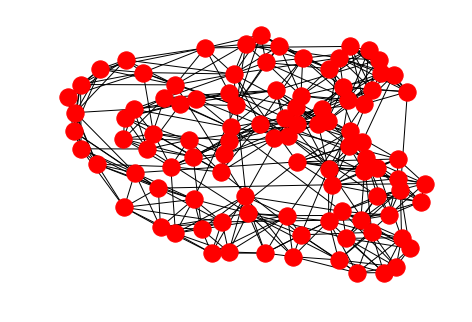

In [49]:
nx.draw(new_nws)

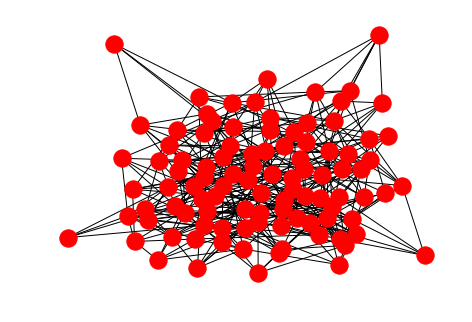

In [50]:
nx.draw(old_ws)

In [51]:
# Solution goes here
def run_one_nws_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    nws = make_nws_graph(n, k, p)    
    mpl = characteristic_path_length(nws)
    cc = clustering_coefficient(nws)
    print(mpl, cc)
    return mpl, cc

def run_nws_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for NWS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns: sequence of (mpl, cc) pairs
    """
    res = {}
    for p in ps:
        print(p)
        res[p] = []
        for _ in range(iters):
            res[p].append(run_one_nws_graph(n, k, p))
    return res

In [52]:
# Solution goes here
res_nws = run_experiment(ps, n=500)

0.0001
19.7412104208 0.66617979798
25.4509018036 0.666666666667
25.4509018036 0.666666666667
25.4509018036 0.666666666667
25.4509018036 0.666666666667
25.4509018036 0.666666666667
18.830244489 0.665548484848
24.0841282565 0.66617979798
23.5991903808 0.665602020202
25.4509018036 0.666666666667
21.8376673347 0.665746464646
25.4509018036 0.666666666667
25.4509018036 0.666666666667
25.4509018036 0.666666666667
22.105002004 0.665602020202
25.4509018036 0.666666666667
25.4509018036 0.666666666667
25.4509018036 0.666666666667
25.4509018036 0.666666666667
25.4509018036 0.666666666667
0.000316227766017
21.639238477 0.665746464646
16.2131863727 0.665248484848
21.5858116232 0.665890909091
25.0819318637 0.665602020202
23.406757515 0.665890909091
17.1317835671 0.664826262626
25.4509018036 0.666666666667
21.6663647295 0.665890909091
19.1333466934 0.665404040404
25.4509018036 0.666666666667
17.3617955912 0.665115151515
25.4509018036 0.666666666667
20.053995992 0.666035353535
25.4509018036 0.666666666

[24.325503406813628, 21.586901002004009, 17.455157515030063, 12.144382364729459, 7.8899835671342684, 5.1367230460921842, 3.9183803607214429, 3.2263490981963932, 2.938807615230461]
[0.6664095959595957, 0.66588712121212112, 0.66454272727272723, 0.66031031746031743, 0.64927958152958143, 0.60746736041736038, 0.49198174714174703, 0.22726416903358082, 0.018596521323533708]


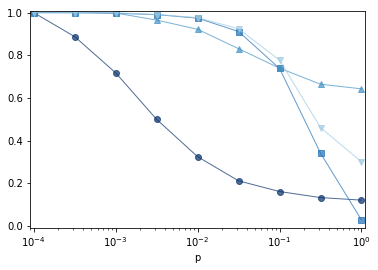

In [53]:
# Solution goes here

L_nws = []
C_nws = []
for p, t in sorted(res_nws.items()):
    mpls, ccs = zip(*t)
    mpl = np.mean(mpls)
    cc = np.mean(ccs)
    L_nws.append(mpl)
    C_nws.append(cc)
    
print(L_nws)
print(C_nws)

L_nws = np.array(L_nws) / L_nws[0]
C_nws = np.array(C_nws) / C_nws[0]

thinkplot.plot(ps, L_nws, style='o-', linewidth=1)
thinkplot.plot(ps, C_nws, style='s-', linewidth=1)
thinkplot.plot(ps, L, style='^-', linewidth=1)
thinkplot.plot(ps, C, style='v-', linewidth=1)
thinkplot.config(xlabel='p', xscale='log',
                 xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

# Solution goes here
When comparing two initially generated graphs by the Newman-Watts-Strogatz and Watts-Strogatz models, we see that for p=0.5, the NWS model has a comparable (and slightly higher) path length, and the clustering coefficient is significantly higher.

After running the similar experiments to see how the clustering coefficient and the characteristic path length drop off, we see that the clustering coefficient stays pretty similar to the WS model, and the path length decreases quite a bit quicker.

Based off of these findings, I think that this method exhibits similar qualities to the small world model. It is worth noting that the number of edges increases as p increases, since we are adding edges rather than replacing them. 

**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [54]:
def bfs(top_node, visit):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [top_node]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visit(curr_node)            # Visit the node
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in curr_node.children
                     if c not in visited and c not in queue)

# Solution goes here
A huge performance hit in this algorithm is the `queue.pop(0)`. Since the queue is not actually a deque, this will incur an expense of $O(len(queue))$ every time it is run. Additionally, the last line `c not in queue` will also incur an expensive linear search through the queue.